In [1]:
import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [3]:
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [4]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

login(os.environ['HF_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
from items import Item

In [8]:
%matplotlib inline

In [9]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)
    

In [10]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Refrigerator Door Handle Replacement for Frigidaire Refrigerator - Compatible with Black Door Handle - UpStart Components Brand
UpStart Components Replacement Refrigerator Door Handle for Frigidaire RefrigeratorPlease note This is an UpStart Components Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by UpStart Components. UpStart Components Replacement Refrigerator Door Handle for Frigidaire Refrigerator Ultra durable, high quality material resists wear and tear over time. Easy at-home installation. An affordable way to extend the

Price is $25.00


In [11]:
print(train[0].price)

24.99


In [12]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [13]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $84.00 Truth: $26.97 Error: $57.03 SLE: 1.24 Item: Discount Parts Direct 316075104 Oven Bak...
2: Guess: $787.00 Truth: $36.99 Error: $750.01 SLE: 9.19 Item: BestRec CHK100ZW Dryer Vent Heat Keeper ...
3: Guess: $622.00 Truth: $41.33 Error: $580.67 SLE: 7.23 Item: Fuxury 12 Inch Impulse Bag Sealer, Heat ...
4: Guess: $721.00 Truth: $45.02 Error: $675.98 SLE: 7.58 Item: Compatible Dryer Heating Element for Whi...
5: Guess: $266.00 Truth: $13.97 Error: $252.03 SLE: 8.30 Item: 694089 Dryer Blower Wheel by FreeCat,Rep...
6: Guess: $144.00 Truth: $55.65 Error: $88.35 SLE: 0.88 Item: Compatible with Whirlpool WP61005273 Ref...
7: Guess: $353.00 Truth: $20.99 Error: $332.01 SLE: 7.72 Item: Replacement Aluminum Range Hood Filter C...
8: Guess: $873.00 Truth: $30.68 Error: $842.32 SLE: 11.01 Item: Lifetime Appliance Parts UPGRADED 240350...
9: Guess: $67.00 Truth: $57.99 Error: $9.01 SLE: 0.02 Item: OEM LG Refrigerator Door Bin Basket Shel...
10: Guess: $154.00 Truth: $8.99 Error: $14

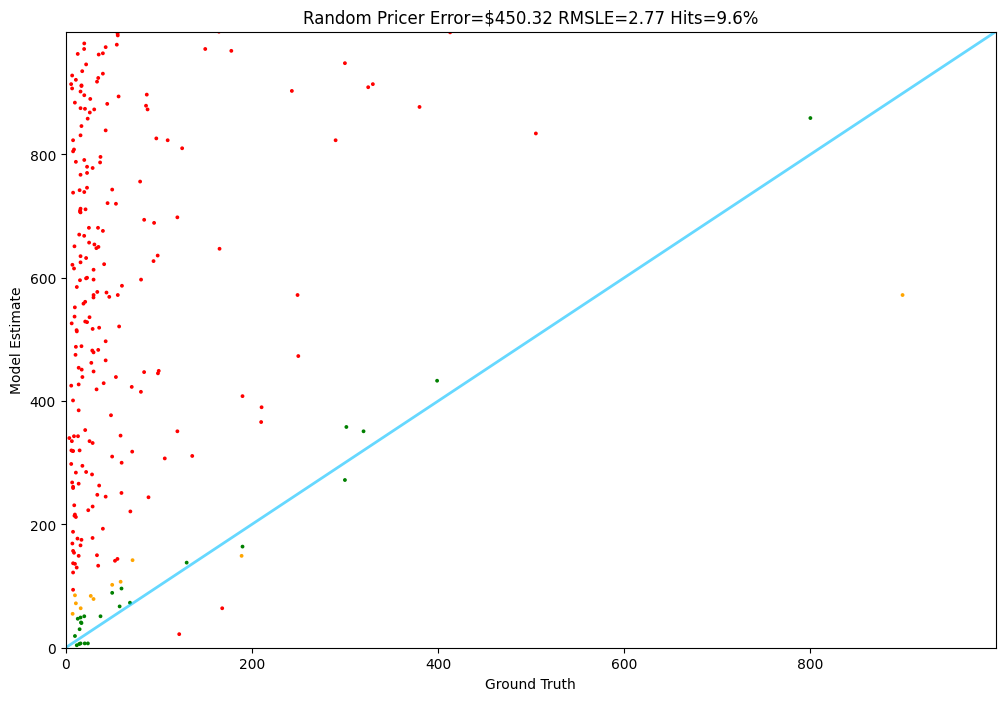

In [58]:
random.seed(89)

Tester.test(random_pricer)

In [18]:
training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $58.44 Truth: $26.97 Error: $31.47 SLE: 0.57 Item: Discount Parts Direct 316075104 Oven Bak...
2: Guess: $58.44 Truth: $36.99 Error: $21.45 SLE: 0.20 Item: BestRec CHK100ZW Dryer Vent Heat Keeper ...
3: Guess: $58.44 Truth: $41.33 Error: $17.11 SLE: 0.12 Item: Fuxury 12 Inch Impulse Bag Sealer, Heat ...
4: Guess: $58.44 Truth: $45.02 Error: $13.42 SLE: 0.07 Item: Compatible Dryer Heating Element for Whi...
5: Guess: $58.44 Truth: $13.97 Error: $44.47 SLE: 1.90 Item: 694089 Dryer Blower Wheel by FreeCat,Rep...
6: Guess: $58.44 Truth: $55.65 Error: $2.79 SLE: 0.00 Item: Compatible with Whirlpool WP61005273 Ref...
7: Guess: $58.44 Truth: $20.99 Error: $37.45 SLE: 0.99 Item: Replacement Aluminum Range Hood Filter C...
8: Guess: $58.44 Truth: $30.68 Error: $27.76 SLE: 0.40 Item: Lifetime Appliance Parts UPGRADED 240350...
9: Guess: $58.44 Truth: $57.99 Error: $0.45 SLE: 0.00 Item: OEM LG Refrigerator Door Bin Basket Shel...
10: Guess: $58.44 Truth: $8.99 Error: $49.45 SLE: 3.18 It

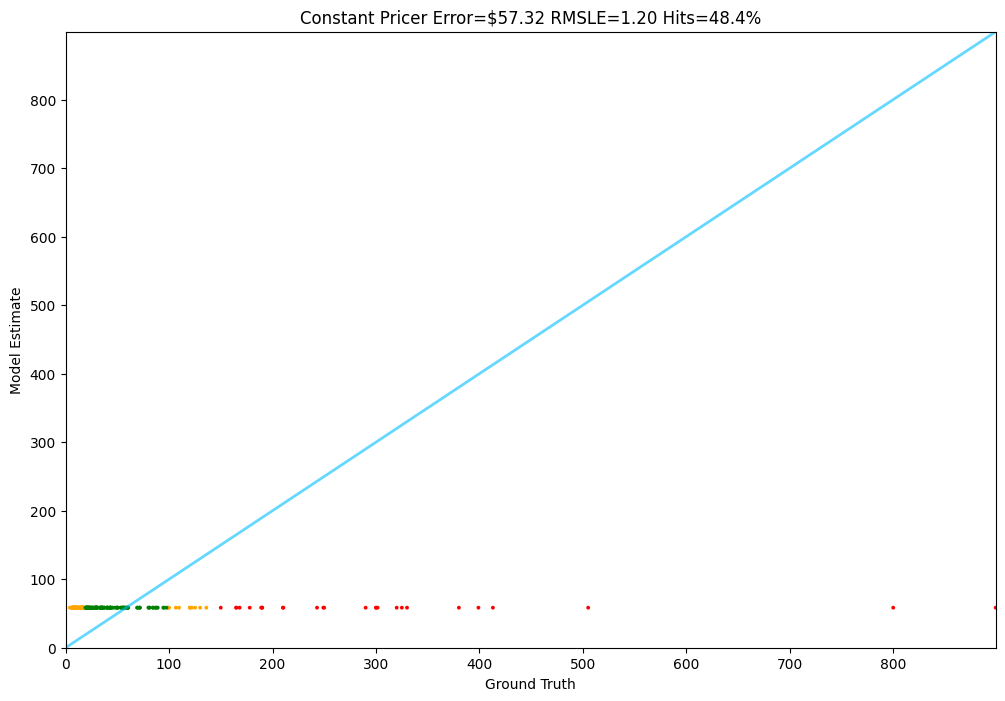

In [19]:
Tester.test(constant_pricer)


In [20]:
train[0].details

'{"Manufacturer": "UpStart Components", "Part Number": "AP-5304506471-DL469", "Finish": "Matte", "Number Of Pieces": "1", "Special Features": "Easy to Install, Durable", "Best Sellers Rank": {"Tools & Home Improvement": 1004726, "Refrigerator Replacement Handles": 1248}, "Date First Available": "May 18, 2019", "Brand": "UpStart Components", "Number of Pieces": "1", "Special Feature": "Easy to Install, Durable", "Unit Count": "1.0 Count", "Style Compatible": "", "": "Finish Type Matte"}'

In [21]:
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)


In [22]:
train[0].features.keys()

dict_keys(['Manufacturer', 'Part Number', 'Finish', 'Number Of Pieces', 'Special Features', 'Best Sellers Rank', 'Date First Available', 'Brand', 'Number of Pieces', 'Special Feature', 'Unit Count', 'Style Compatible', ''])

In [24]:
feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(30)

[('Date First Available', 20268),
 ('Best Sellers Rank', 19112),
 ('Item Weight', 17261),
 ('Item model number', 15210),
 ('Manufacturer', 14754),
 ('Part Number', 14416),
 ('Batteries Required?', 12891),
 ('Brand', 11993),
 ('Product Dimensions', 11872),
 ('Batteries Included?', 10620),
 ('Is Discontinued By Manufacturer', 8100),
 ('Material', 7792),
 ('Color', 7766),
 ('Package Dimensions', 6724),
 ('Brand Name', 5286),
 ('Included Components', 5158),
 ('Item Package Quantity', 4822),
 ('Country of Origin', 4356),
 ('Model Info', 3992),
 ('Special Features', 2797),
 ('Shape', 2764),
 ('Number of Pieces', 2740),
 ('Special Feature', 2676),
 ('Material Type', 2378),
 ('Style', 2335),
 ('Size', 2152),
 ('Voltage', 2111),
 ('Item Dimensions LxWxH', 1986),
 ('Unit Count', 1812),
 ('External Testing Certification', 1685)]

In [25]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [26]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [27]:
average_weight = sum(weights)/len(weights)
average_weight

3.854292407757454

In [28]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [29]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [30]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

239597.24737797354

In [31]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [32]:
def get_text_length(item):
    return len(item.test_prompt())

In [33]:
brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1


brands.most_common(40)

[('GE', 431),
 ('Upstart Battery', 417),
 ('Whirlpool', 401),
 ('Frigidaire', 337),
 ('Supplying Demand', 252),
 ('UpStart Components', 175),
 ('SAMSUNG', 162),
 ('BlueStars', 127),
 ('Supco', 110),
 ('ICEPURE', 104),
 ('LG', 99),
 ('Broan-NuTone', 86),
 ('AMI PARTS', 85),
 ('Lifetime Appliance Parts', 80),
 ('PartsBroz', 74),
 ('Swift Green Filters', 69),
 ('Beaquicy', 68),
 ('Air Filter Factory', 62),
 ('Waterdrop', 59),
 ('Nostalgic Warehouse', 59),
 ('Electrolux', 55),
 ('Generic', 54),
 ('Wowfeel', 52),
 ('Aqua Fresh', 49),
 ('HQRP', 48),
 ('Melitta', 47),
 ('Empava', 47),
 ('AQUA CREST', 46),
 ('Range Kleen', 44),
 ('PUREPLUS', 43),
 ('BUNN', 41),
 ('Seentech', 40),
 ('Tier1', 40),
 ('Nispira', 40),
 ('EXCELPURE', 38),
 ('Edgewater Parts', 38),
 ('Denali Pure', 38),
 ('GOLDEN ICEPURE', 38),
 ('COSTWAY', 34),
 ('BRBHOM', 34)]

In [34]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [36]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [37]:
get_features(train[0])

{'weight': 3.854292407757454,
 'rank': 502987.0,
 'text_length': 946,
 'is_top_electronics_brand': 0}

In [38]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [39]:
np.random.seed(42)

feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 6.687555608332405
rank: -2.186673103238776e-06
text_length: 0.018915886554029038
is_top_electronics_brand: 12.212155075665802
Intercept: 18.2752149295248
Mean Squared Error: 4708.199564144757
R-squared Score: 0.5831166795920081


In [40]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $38.92 Truth: $26.97 Error: $11.95 SLE: 0.13 Item: Discount Parts Direct 316075104 Oven Bak...
2: Guess: $59.84 Truth: $36.99 Error: $22.85 SLE: 0.22 Item: BestRec CHK100ZW Dryer Vent Heat Keeper ...
3: Guess: $91.75 Truth: $41.33 Error: $50.42 SLE: 0.62 Item: Fuxury 12 Inch Impulse Bag Sealer, Heat ...
4: Guess: $44.63 Truth: $45.02 Error: $0.39 SLE: 0.00 Item: Compatible Dryer Heating Element for Whi...
5: Guess: $36.37 Truth: $13.97 Error: $22.40 SLE: 0.84 Item: 694089 Dryer Blower Wheel by FreeCat,Rep...
6: Guess: $58.81 Truth: $55.65 Error: $3.16 SLE: 0.00 Item: Compatible with Whirlpool WP61005273 Ref...
7: Guess: $34.01 Truth: $20.99 Error: $13.02 SLE: 0.22 Item: Replacement Aluminum Range Hood Filter C...
8: Guess: $44.08 Truth: $30.68 Error: $13.40 SLE: 0.12 Item: Lifetime Appliance Parts UPGRADED 240350...
9: Guess: $57.26 Truth: $57.99 Error: $0.73 SLE: 0.00 Item: OEM LG Refrigerator Door Bin Basket Shel...
10: Guess: $60.49 Truth: $8.99 Error: $51.50 SLE: 3.30 Ite

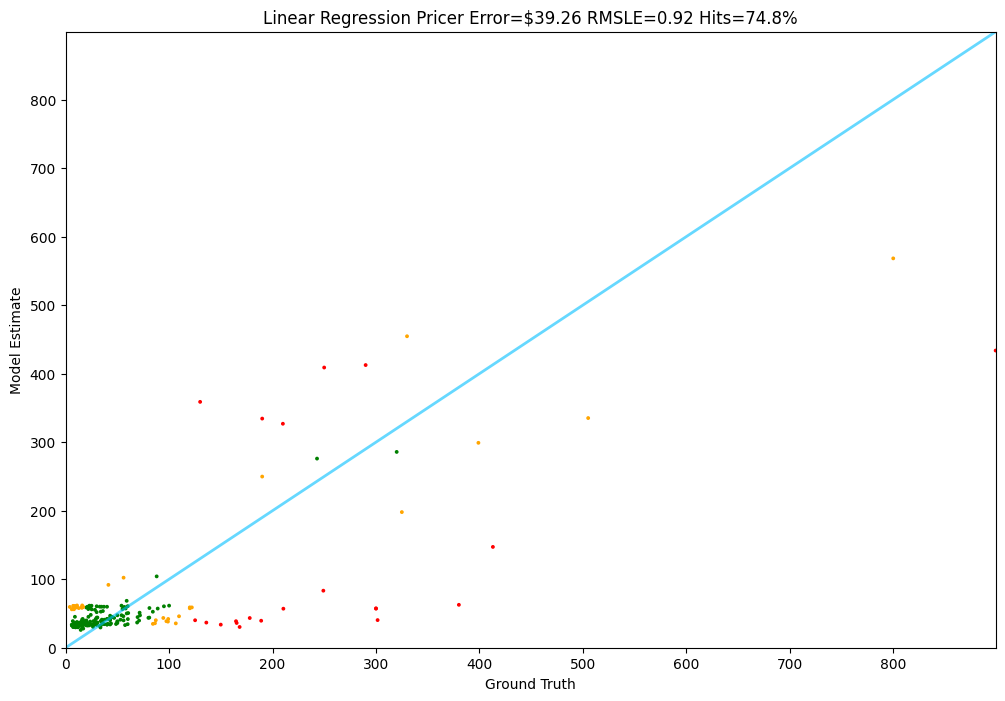

In [41]:

Tester.test(linear_regression_pricer)

In [42]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [43]:
np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [44]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $11.03 Truth: $26.97 Error: $15.94 SLE: 0.71 Item: Discount Parts Direct 316075104 Oven Bak...
2: Guess: $126.75 Truth: $36.99 Error: $89.76 SLE: 1.47 Item: BestRec CHK100ZW Dryer Vent Heat Keeper ...
3: Guess: $41.80 Truth: $41.33 Error: $0.47 SLE: 0.00 Item: Fuxury 12 Inch Impulse Bag Sealer, Heat ...
4: Guess: $27.34 Truth: $45.02 Error: $17.68 SLE: 0.24 Item: Compatible Dryer Heating Element for Whi...
5: Guess: $60.98 Truth: $13.97 Error: $47.01 SLE: 2.02 Item: 694089 Dryer Blower Wheel by FreeCat,Rep...
6: Guess: $85.78 Truth: $55.65 Error: $30.13 SLE: 0.18 Item: Compatible with Whirlpool WP61005273 Ref...
7: Guess: $45.10 Truth: $20.99 Error: $24.11 SLE: 0.55 Item: Replacement Aluminum Range Hood Filter C...
8: Guess: $136.96 Truth: $30.68 Error: $106.28 SLE: 2.16 Item: Lifetime Appliance Parts UPGRADED 240350...
9: Guess: $79.44 Truth: $57.99 Error: $21.45 SLE: 0.10 Item: OEM LG Refrigerator Door Bin Basket Shel...
10: Guess: $6.56 Truth: $8.99 Error: $2.43 SLE: 0.08 

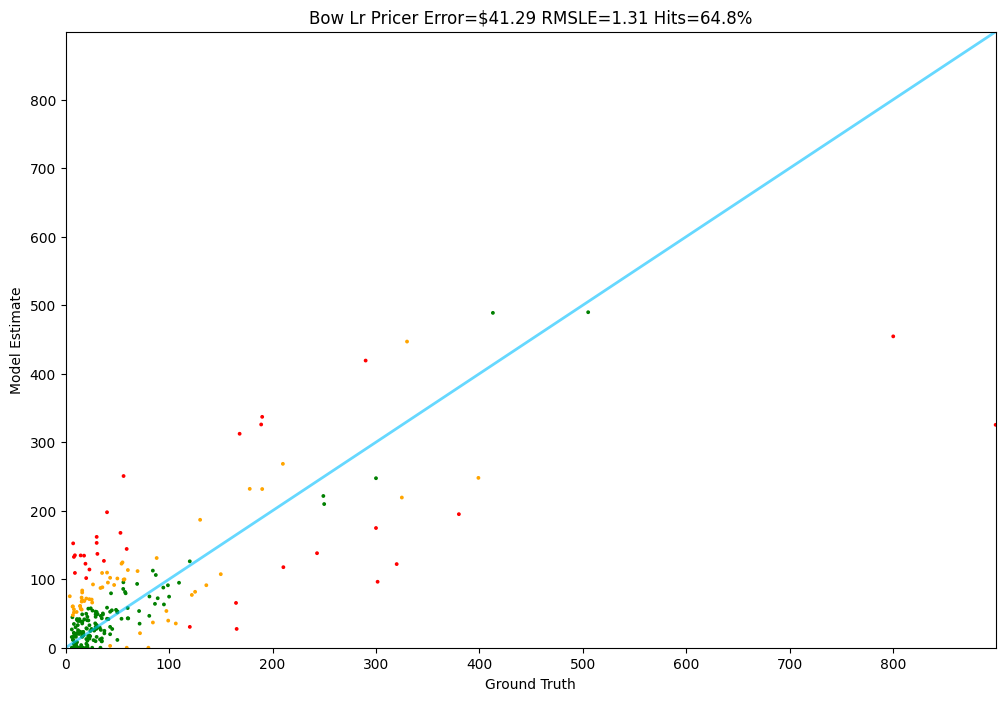

In [45]:

Tester.test(bow_lr_pricer)

In [46]:
np.random.seed(42)

processed_docs = [simple_preprocess(doc) for doc in documents]

w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [ ]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

X_w2v = np.array([document_vector(doc) for doc in documents])

In [48]:
word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [49]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $16.89 Truth: $26.97 Error: $10.08 SLE: 0.20 Item: Discount Parts Direct 316075104 Oven Bak...
2: Guess: $141.63 Truth: $36.99 Error: $104.64 SLE: 1.75 Item: BestRec CHK100ZW Dryer Vent Heat Keeper ...
3: Guess: $80.12 Truth: $41.33 Error: $38.79 SLE: 0.42 Item: Fuxury 12 Inch Impulse Bag Sealer, Heat ...
4: Guess: $23.17 Truth: $45.02 Error: $21.85 SLE: 0.41 Item: Compatible Dryer Heating Element for Whi...
5: Guess: $38.91 Truth: $13.97 Error: $24.94 SLE: 0.96 Item: 694089 Dryer Blower Wheel by FreeCat,Rep...
6: Guess: $22.85 Truth: $55.65 Error: $32.80 SLE: 0.75 Item: Compatible with Whirlpool WP61005273 Ref...
7: Guess: $50.32 Truth: $20.99 Error: $29.33 SLE: 0.72 Item: Replacement Aluminum Range Hood Filter C...
8: Guess: $79.79 Truth: $30.68 Error: $49.11 SLE: 0.88 Item: Lifetime Appliance Parts UPGRADED 240350...
9: Guess: $83.62 Truth: $57.99 Error: $25.63 SLE: 0.13 Item: OEM LG Refrigerator Door Bin Basket Shel...
10: Guess: $6.67 Truth: $8.99 Error: $2.32 SLE: 0.07 

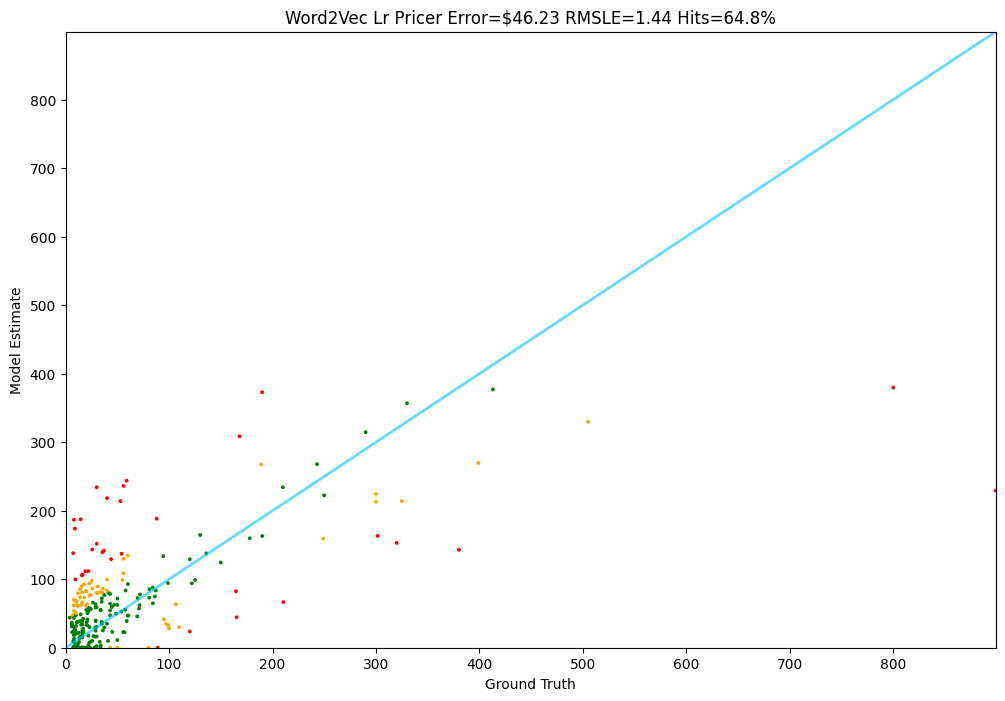

In [50]:
Tester.test(word2vec_lr_pricer)

In [51]:
np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [52]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $31.47 Truth: $26.97 Error: $4.50 SLE: 0.02 Item: Discount Parts Direct 316075104 Oven Bak...
2: Guess: $46.74 Truth: $36.99 Error: $9.75 SLE: 0.05 Item: BestRec CHK100ZW Dryer Vent Heat Keeper ...
3: Guess: $30.08 Truth: $41.33 Error: $11.25 SLE: 0.10 Item: Fuxury 12 Inch Impulse Bag Sealer, Heat ...
4: Guess: $31.26 Truth: $45.02 Error: $13.76 SLE: 0.13 Item: Compatible Dryer Heating Element for Whi...
5: Guess: $29.09 Truth: $13.97 Error: $15.12 SLE: 0.49 Item: 694089 Dryer Blower Wheel by FreeCat,Rep...
6: Guess: $20.81 Truth: $55.65 Error: $34.84 SLE: 0.91 Item: Compatible with Whirlpool WP61005273 Ref...
7: Guess: $20.45 Truth: $20.99 Error: $0.54 SLE: 0.00 Item: Replacement Aluminum Range Hood Filter C...
8: Guess: $32.61 Truth: $30.68 Error: $1.93 SLE: 0.00 Item: Lifetime Appliance Parts UPGRADED 240350...
9: Guess: $55.84 Truth: $57.99 Error: $2.15 SLE: 0.00 Item: OEM LG Refrigerator Door Bin Basket Shel...
10: Guess: $10.35 Truth: $8.99 Error: $1.36 SLE: 0.02 Item: 

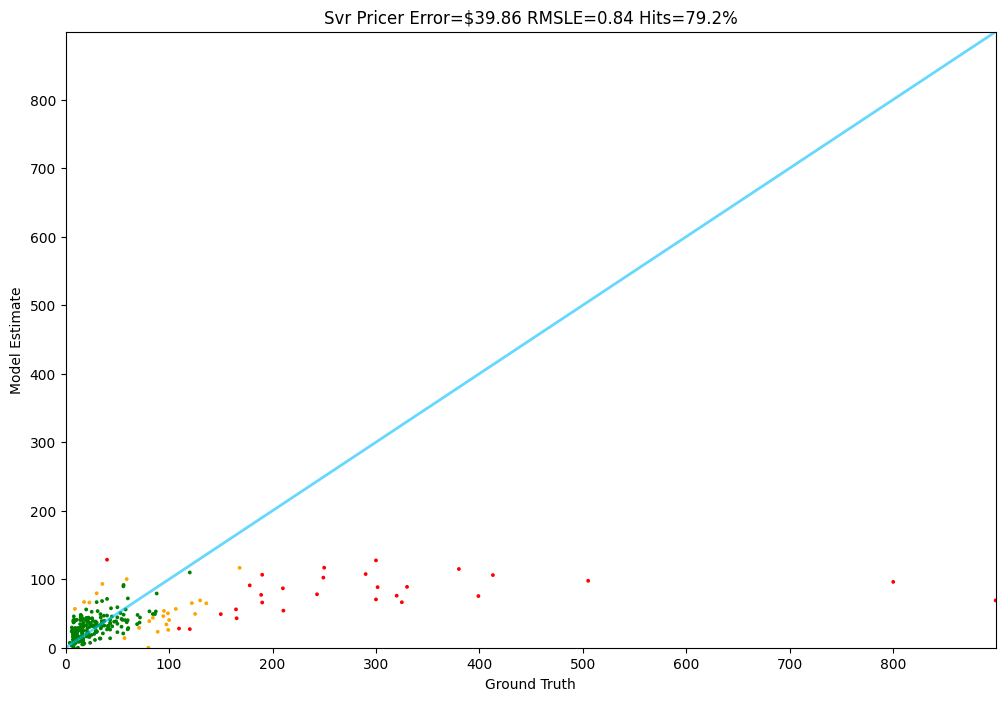

In [53]:
Tester.test(svr_pricer)

In [54]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $29.66 Truth: $26.97 Error: $2.69 SLE: 0.01 Item: Discount Parts Direct 316075104 Oven Bak...
2: Guess: $43.86 Truth: $36.99 Error: $6.87 SLE: 0.03 Item: BestRec CHK100ZW Dryer Vent Heat Keeper ...
3: Guess: $47.77 Truth: $41.33 Error: $6.44 SLE: 0.02 Item: Fuxury 12 Inch Impulse Bag Sealer, Heat ...
4: Guess: $41.63 Truth: $45.02 Error: $3.39 SLE: 0.01 Item: Compatible Dryer Heating Element for Whi...
5: Guess: $16.67 Truth: $13.97 Error: $2.70 SLE: 0.03 Item: 694089 Dryer Blower Wheel by FreeCat,Rep...
6: Guess: $106.58 Truth: $55.65 Error: $50.93 SLE: 0.41 Item: Compatible with Whirlpool WP61005273 Ref...
7: Guess: $44.94 Truth: $20.99 Error: $23.95 SLE: 0.54 Item: Replacement Aluminum Range Hood Filter C...
8: Guess: $45.40 Truth: $30.68 Error: $14.72 SLE: 0.15 Item: Lifetime Appliance Parts UPGRADED 240350...
9: Guess: $62.25 Truth: $57.99 Error: $4.26 SLE: 0.00 Item: OEM LG Refrigerator Door Bin Basket Shel...
10: Guess: $8.98 Truth: $8.99 Error: $0.01 SLE: 0.00 Item: W

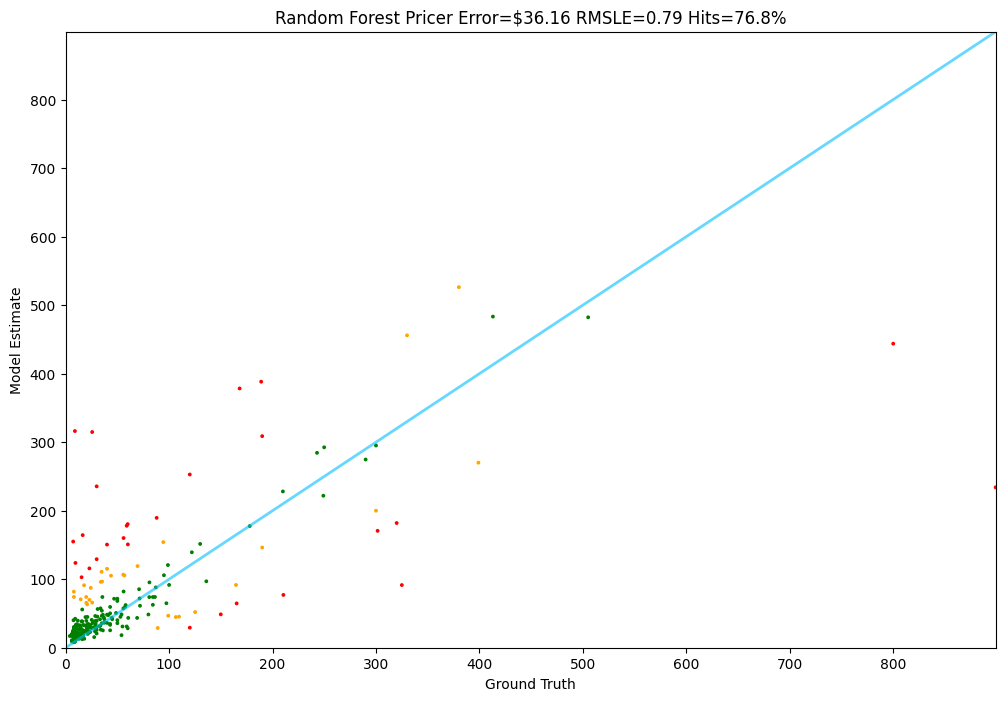

In [56]:
Tester.test(random_forest_pricer)